# Parameter fitting using Maximum Likelihood Estimation (MLE)

This notebook requires the `pracma` package. If you do not have this package installed, run this block of code:

In [ ]:
install.packages("pracma",repos='http://cran.us.r-project.org')

If you already have `pracma` installed, run this block:

In [2]:
library(pracma)

Warning message:
"package 'pracma' was built under R version 3.5.3"

This next block makes sure all the plots we produce are a manageable size:

In [3]:
options(repr.plot.width=5, repr.plot.height=5)

## Introduction

In this workshop, we will introduce the basics of parameter estimation using Maximum Likelihood Estimation (MLE). Our epidemiological focus is on the early stages of an outbreak, but the concepts we introduce are important to mathematical modelling in general. The calculations we will outline in this model are based on those conducted in Lloyd-Smith *et al.*'s 2005 Paper [Superspreading and the effect of individual variation on disease emergence](https://www.nature.com/articles/nature04153). The workshop is designed to be self-contained, but if you would like to read the paper and are unable to access it, let one of the workshop coordinators know.

## Transmission tree data

In this notebook, we will deal with *transmission tree* data. Given detailed information about the early stages of an outbreak, it is sometimes possible to reconstruct the specific person-to-person transmission events which make up the outbreak. This reconstruction is in itself a difficult statistical problem, and in this notebook we will make use of reconstructed chains as they appear in the literature.

<img src="AtemporalBranchingProcess.png" alt="drawing" width="500"/>

The early spread of the infection is characterised by the degree distribution of this tree - that is, the number of secondary cases generated by each case. As the epidemic progresses and the level of immunity in the population increases, this distribution will change, and the average number of secondary cases will decrease with each generation. For the first few generations of spread, however, the level of immunity will remain low and so we can treat the distribution of secondary cases as fixed. In this regime, we can think about the degree distribution of the first few generations of spread.

In the following block of code, we define a vector `sars_data`, containing the frequencies of secondary case numbers in an outbreak of SARS which took place in Singapore in 2003. Plotting the data in a histogram shows that the majority of cases generate no secondary cases, while a few cases are responsible for the majority of the spread. Note that we have binned the data into `max(sars_data)+1` bins since the first (and most full) bin contains all the cases which failed to generate any secondary cases.

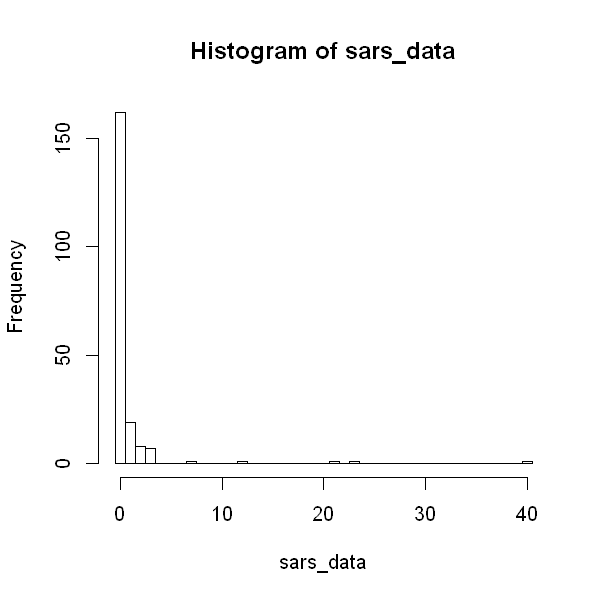

In [4]:
sars_data<-c(rep(0,162),rep(1,19),rep(2,8),rep(3,7),7,12,21,23,40)
hist(sars_data,breaks=seq(-0.5,max(sars_data)+0.5))

## The Poisson model

Given a transmission chain, we would like to develop a mathematical model which we can use to analyse the dynamics of the outbreak. Suppose that each case is infectious for a fixed period $\gamma$ and randomly generates new infections at a constant rate $\tau$ during this period. This is (arguably) the simplest model of a transmission process that one can define, and the resulting secondary case distribution will be Poisson distributed with mean $\lambda=\tau/\gamma$. The purpose of a model is to understand the processes which generate our data, and to make predictions about the future behaviour of our system. In our situation, we would like to know the probability that a given case generates $x$ further cases, which under the Poisson model with parameter $\lambda$ is given by
$$
P(x|\lambda)=\frac{e^{-\lambda}\lambda^x}{x!}.
$$
This formula should allow us to predict the future course of the epidemic - except we don't know what value of $\lambda$ to use! To solve this problem we need to fit $\lambda$ to the data by finding the value which is most consistent with it. To do this, we need to define a *likelihood* function. This tells us the probability that a certain parameter value generated our data:
$$
L(\lambda|\mathbf{x})=P(\mathbf{x}|\lambda).
$$
Here $\mathbf{x}$ is just the set of secondary case counts stored in the vector `sars_data`. The idea behind MLE is that the "best" value for our parameter $\lambda$ should be the one that assigns the highest probability to our data $\mathbf{x}$. We refer to this value as the *maximum likelihood estimate* for $\lambda$ and denote it $\hat{\lambda}$. Before we begin the process of calculating $\lambda$, use the box below to plot the Poisson probability mass function `dpois(x,lambda)` with `x=sars_data` for a range of $\lambda$ values (you should find that ranging from 0 to 2 is sufficient to understand what is going on here). Since `dpois` outputs the vector of probabilities assigned to each point in the dataset, you will need to take the product of these point probabilities to get the joint probability of the entire dataset.

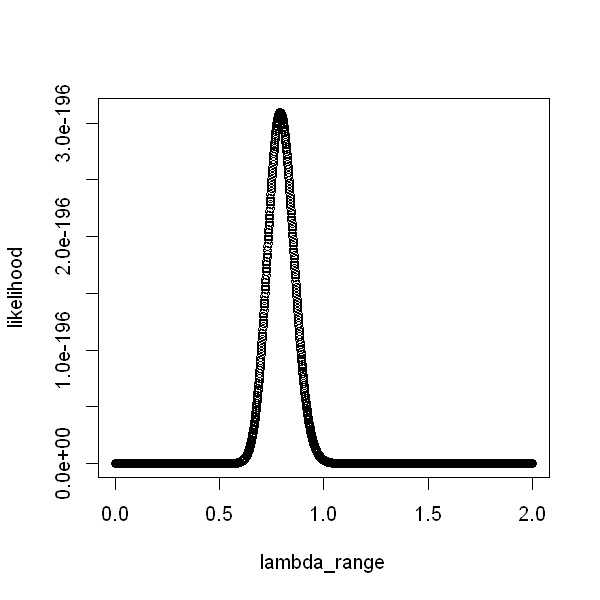

In [5]:
#SOLUTION

lambda_range<-seq(from=0,to=2,by=0.001)
likelihood<-numeric(length(lambda_range))
for (i in 1:length(lambda_range)){
    likelihood[i]<-prod(dpois(sars_data,lambda_range[i]))
}
plot(lambda_range,likelihood)

You should notice several things about this plot. The first is that the likelihood values are extremely small, since they are obtained by taking the product of roughly 200 probabilities. Working with the product of lots of small numbers introduces the potential for serious numerical errors. For this reason, rather than working directly with likelihood, we usually work with log likelihood instead. Doing this converts the sum
$$
L(\lambda|\mathbf{x})=P(\mathbf{x}|\lambda)=\prod\limits_{i=1}^n\frac{e^{-\lambda}\lambda^x_i}{x_i!}
$$
into the product
$$
\begin{align}
\log(L(\lambda|\mathbf{x}))=&\sum\limits_{i=1}^n\log((\frac{e^{-\lambda}\lambda^x_i}{x_i!}))\\
=&\sum\limits_{i=1}^n-\lambda+x_i\log(\lambda) -log(x_i!).
\end{align}
$$
Since the logarithm function is a diffeomorphism (i.e. it preserves the sign of a function it is composed with), the log likelihood will have a maximum at the same point as the likelihood, so that finding the maximum of $\log(L(\lambda|\mathbf{x}))$ is sufficient for finding the MLE.

The other interesting feature is the single peak between $\lambda=0.5$ and $\lambda=1$. This tells us that the MLE exists, and should be reasonably easy to find. In the box below, we define functions `poi_log_lh`, which calculates the log likelihood of the Poisson parameter $\lambda$ given data $\mathbf{x}$, and `get_poi_mle`, which estimates the maximum likelihood parameter $\hat{\lambda}$, and carry out this estimation for our SARS example.

In [6]:
poi_log_lh <- function(lambda,data) {
    l<-0
    l=l+sum(log(dpois(data,lambda)))
    return(l)
}

# In the following function, lambda_minmax is a vector containing the range over which we will search for the MLE
get_poi_mle <- function(data,lambda_minmax) {
    f <- function(lambda) {
        return(poi_log_lh(lambda,data))
    }
    lambda_mle <- as.numeric(optimise(f,lambda_minmax,maximum=TRUE)[1])
    return(lambda_mle)
}

lambda_mle = get_poi_mle(sars_data,c(0,max(sars_data)))

cat("MLE is ",lambda_mle,".")

MLE is  0.791043 .

If one refers back to the likelihood plot we made a few blocks ago, it should be clear that we have indeed found the maximum likelihood estimate. In fact, we went to far more effort than was necessary to find it. If you calculate `mean(sars_data)`, you will find that it returns precisely the MLE which we just calculated! One can show without too much effort that the log likelihood function $L(\lambda|\mathbf{x})$ always has a maximum when $\lambda=\frac{1}{n}\sum_ix_i$. In words, the MLE of the Poisson distribution's mean is always given by the sample mean. In fact, this holds true for all the distributions we will encounter today, and in general for a broad class of distributions known as *exponential families*. Note that this is **not** true of parameters in general; as we will see later, for some models the variance given by the maximum likelihood parameters is not necessarily equal to the sample variance.

Let's recap what we've done so far: We have proposed a one parameter model for our data, the Poisson distribution, based on a simple mechanistic principle, and estimated a value for its parameter by maximising the log likelihood of that parameter. How well does our model do at describing the data?

Let's try plotting the fitted Poisson distribution over the empirical distribution from the SARS data:

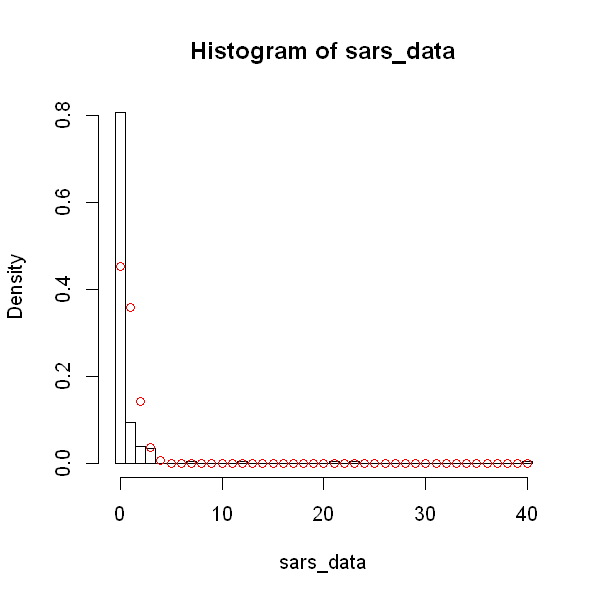

In [7]:
hist(sars_data, breaks=seq(-0.5,max(sars_data)+0.5), probability = TRUE)
points(seq(0,max(sars_data),1),dpois(seq(0,max(sars_data),1),lambda_mle), col = 'red')

It should be immediately clear that our Poisson distribution has done a poor job of capturing the features of this data. Running the box below, you should see that the variance of our data is substantially higher than the mean:

In [8]:
var(sars_data)

[1] 13.75612

Count data with a higher variance than mean is described as *overdispersed* - essentially, the data is much more spread out than would be predicted by a Poisson model (recall that the Poisson distribution has a variance equal to its mean). When we have high levels of overdispersion, we do not expect the Poisson distribution to give a good fit to the data. In our SARS example, the data contains a far higher frequency of zeros than is predicted by the Poisson distribution. This is a common feature of secondary cases data from outbreaks of novel infections, and can be caused by effective quarantining or hospitalisation, high levels of disease-induced illness which impede normal contact behaviour, or the failure of a pathogen to adapt to human physiology and induce human-to-human spread. The data also includes a few very prolific cases whose behaviour is effectively assigned zero probability under the fitted Poisson model. Such individuals are often referred to as *superspreaders*. In Lloyd-Smith *et al.*'s paper, they define superspreaders to be those cases which would fall in the 99th percentile of a Poisson distribution with mean $\bar{x}$. In the box below, use the `qpois` function to calculate the upper 99th percentile of a Poisson distribution with parameter `mean(sars_data)`, and then write a function which takes a set of transmission chain data as an input and then returns the list of superspreaders from that dataset.

In [9]:
#SOLUTION

qpois(.99,mean(sars_data))

identify_superspreaders <- function(data) {
    lambda<-mean(data)
    superspreaders<-data[data>qpois(.99,lambda)]
    return(superspreaders)
}

identify_superspreaders(sars_data)

[1] 3

[1]  7 12 21 23 40

You should find that the superspreaders in the SARS dataset are those individuals which generated 7, 12, 21, 24, and 40 secondary infections. Under the Poisson model, we assumed that all individuals in the dataset had the same infectious period and contact rate. The presence of superspreaders in the data suggests that this is a poor assumption - the individual who generated 40 cases is likely to have behaved very differently to the individual who generated 23 cases, who is in turn likely to have behaved very differently to the 162 individuals who generated no cases at all.

## The negative binomial model

The negative binomial model takes a more flexible approach to infectious transmission than the Poisson model. The negative binomial distribution can be obtained by letting the paramter of a Poisson distribution vary according to a gamma distribution: that is, we draw a random variable $\nu$ from a gamma distribution with mean $\lambda$ (we choose this notation for consistency with the mean of the Poisson distribution) and dispersion (or shape) parameter $k$ and then draw from a Poisson distribution with mean $\nu$. From an epidemiological perspective, we are saying that each individual's infectivity (combining their infectious period and the number and intensity of their contacts) is drawn from the gamma distribution with parameters $(\lambda,k)$. This allows for individual-level variation which has the potential to capture superspreading behaviour. The resulting negative binomial distribution is also parameterised by $\lambda$ and $k$.

An important property of the negative binomial distribution is that its variance is always greater than its mean, so that negative binomially distributed data is always overdispersed. The variance-to-mean ratio of the negative binomial is given by $1+\lambda/k$, so that as $k$ decreases the distribution becomes more overdispersed. In the specific case $k=1$, the negative binomial is identical to the geometric distribution, which has a variance-to-mean ratio of $1+\lambda$. The geometric distribution is relevant in epidemiological contexts because it can be obtained as a Poisson distribution with exponentially-distributed mean. In the standard SIR model, individuals are infectious for exponentially-distributed periods and make contacts at the points of a Poisson process, so that the geometric distribution describes the distribution of secondary cases in this model.

In R (and also in most other scientific programming languages), a slightly different parameterisation of the gamma and negative binomial distributions are used. The pmf of the negative binomial distribution is calculated using the function `dnbinom(x,k,p)`. We can translate from our parameterisation to the one underlying this function using the formula $p=1-\lambda/(\lambda+k)$.

Use the next box to write a function `nb_log_lh(lambda,k,data)` which uses the function `dnbinom` with arguments `(x,k,1-lambda/(lambda+k))` to calculate the log likelihood of a set of negative binomial parameters:

In [10]:
#SOLUTION

nb_log_lh <- function(lambda,k,data) {
    l<-0
    for (x in  data) {
        l=l+log(dnbinom(x,k,1-lambda/(lambda+k)))
    }
    return(l)
}

If your function `nb_log_lh` correctly calculates the log likelihood of the parameters $\lambda$ and $k$, then the following function `get_nb_mle` will find the maximum likelihood estimates of the parameters given a dataset:

In [11]:
get_nb_mle <- function(data,k_minmax) {
    lambda_mle<-mean(data)
    f <- function(k) {
        return(nb_log_lh(lambda_mle,k,data))
    }
    k_mle<-as.numeric(optimise(f,k_minmax,maximum=TRUE)[1])
    return(c(lambda_mle,k_mle))
}

Try using the function to find the maximum likelihood estimates. You should find that $\hat{\lambda}=0.791$ and $\hat{k}=0.093$.

In [12]:
#SOLUTION

mles = get_nb_mle(sars_data,c(0,max(sars_data)))
lambda_mle = mles[1]
k_mle = mles[2]
cat("MLEs are lambda = ",lambda_mle,", k = ",k_mle,".")

MLEs are lambda =  0.7910448 , k =  0.09303093 .

Plotting the fitted Poisson and negative binomial models over the data shows that the negative binomial attains a substantially better fit:

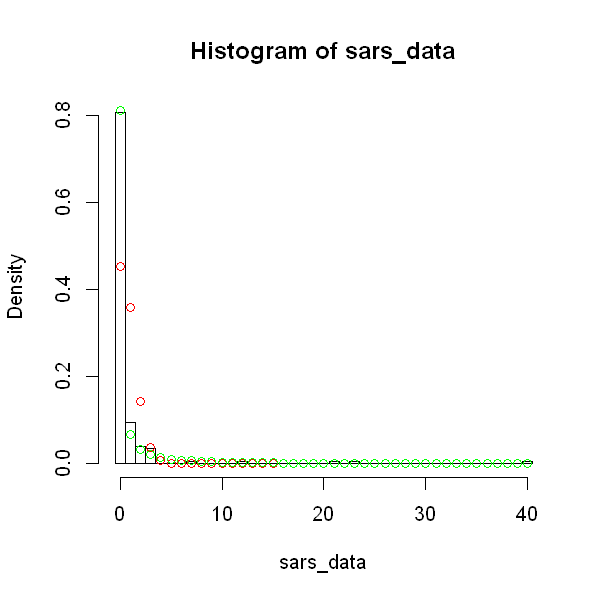

In [13]:
hist(sars_data, breaks=seq(-0.5,max(sars_data)+0.5), probability = TRUE)
points(seq(0,max(sars_data),1),dpois(seq(0,max(sars_data),1),mean(sars_data)), col = 'red')
points(seq(0,max(sars_data),1),dnbinom(seq(0,max(sars_data),1),k_mle,1-lambda_mle/(lambda_mle+k_mle)), col = 'green')

## Akaike Information Criterion

Based on the plot above, the negative binomial distribution offers a much better description of the SARS outbreak data than the Poisson distribution. Ideally, we would like a slightly more formal way to assess which model is best. One way to do this is by calculating the \emph{Akaike Information Criterion} (AIC) of the two models given the data. The AIC for a model with MLE parameters $\hat{\mathbf{\theta}}$ given the data $\mathbf{x}$ is given by the following formula:
$$
AIC=2K-2\log{L(\hat{\mathbf{\theta}}|\mathbf{x})}.
$$
Here $K$ is the number of model parameters, i.e. the length of the vector $\mathbf{\theta}$. The idea here is that the AIC weighs the number of parameters used in the model against its ability to model the data, and models with smaller AICs are considered better than models with larger AICs. The factor of $2K$ helps us to avoid models which \emph{overfit} to a dataset. While we can always use a model with lots of parameters to achieve a very close fit to data, this makes the fit very dependent on random features of the sample data which may not be representative of the larger population from which the sample is drawn. From a slightly more mechanistic and philosophical point of view, the number of parameters in a model corresponds to the complexity of the mechanism it proposes to explain the data, so that a model with fewer parameters proposes a simpler explanation for the data.

In the box below, use the functions `poi_log_lh` and `nb_log_lh` to calculate the AIC for the Poisson and negative binomial models. You should find that the negative binomial model achieves a much lower AIC than the Poisson model.

In [14]:
#SOLUTION



## Proportional contributions of cases

The negative binomial distribution can achieve a close fit to epidemiological count data because it allows for natural variation in individual-level infectivity, which may be the result in differences in social behaviour (i.e. more gregarious versus less gregarious individuals) or in physiological response to infection (i.e. severe disease with lots of coughing/sneezing versus asymptomatic cases with little or no shedding). This variation is captured by a gamma distribution. Plotting this gamma distribution can give us an indication of how infectivity is distributed, but it is more interesting to plot the proportion of cases which give rise to a proportion of infection. To understand why this is interesting, suppose that the majority of infection could be traced to a small number of cases. If we could identify these cases, then targetting control measures towards them would be a more effective intervention than targetting the entire population equally. The specific case where 80% of infections can be traced to 20% of cases is an example of the [Pareto principle](en.wikipedia.org/wiki/Pareto_principle) or "80-20 rule", which states that for many common phenomena 20% of causes are responsible for 80% of effects.

Recall that we used $\nu$ to denote the individual-level reproductive ratio, the expected number of cases a case generates. For each case, $\nu$ is drawn from a gamma distribution, whose pdf we denote by $f(\nu|\lambda,k)$. Let $F_{\mathrm{Trans}}(y|\lambda,k)$ denote the proportion of all cases generated by cases with $\nu\leq y$, given the parameters $(\lambda,k)$. This proportion should be directly proportional to $\int\limits_0^yuf(u|\lambda,k)\mathrm{d}u$, since the expression inside the integral is just the number of cases generated by each individual with $\nu=u$ weighted by the proportion of such individuals in the set of all cases. Observing that when $y=\infty$ this integral gives the expectation of the gamma distribution, the appropriate constant of proportionality is given by $1/\lambda$. Thus,
$$
F_{\mathrm{Trans}}(y|\lambda,k)=\frac{1}{\lambda}\int\limits_0^yuf(u|\lambda,k)\mathrm{d}u.
$$
One can evaluate this analytically to find that
$$
F_{\mathrm{Trans}}(y|\lambda,k)=\frac{\gamma(\frac{k}{\lambda}x,k+1)}{\Gamma(k+1)},
$$
where $\gamma(.,.)$ is the (lower) incomplete gamma function and $\Gamma(.)$ is the gamma function. The ratio between the two is the \emph{regularised gamma function}, for which a function exists in the `pracma` R package. `gammainc` outputs a column vector whose first two entries are the lower and upper incomplete gamma functions and whose third is the regularised gamma function. Thus, to calculate $F_{\mathrm{Trans}}(y|\lambda,k)$, we need to call `gammainc(y*k/lambda,k+1)[3]`.

In the box below, write a function `transmission_proportion(y,lambda,k)` which calculates $F_{\mathrm{Trans}}(y|\lambda,k)$ for a vector of $y$ values.

In [15]:
#SOLUTION

transmission_proportion <- function(x,lambda,k) {
    F<-numeric(length(x))
    for (i in 1:length(x)){
        F[i]=gammainc(x[i]*k/lambda,k+1)[3]
    }
    return(F)
}

The proportion of infection generated by individuals with $\nu>y$ is given by $1-F_{\mathrm{Trans}}(y)$, and the proportion of individuals with $\nu>y$ is given by $1-F_{\nu}(y)$, where $F_{\nu}(y)=\int\limits_0^yf(u|\lambda,k)\mathrm{d}u$ is the CDF of $\nu$. In the box below, we plot $1-F_{\mathrm{Trans}}$ against $1-F_{\nu}$. If your function `transmission_proportion` works correctly, your plot should look something like an upside-down 'L' shape, with almost all the infection generated by a tiny proportion of cases - clear evidence of a superpreading effect!

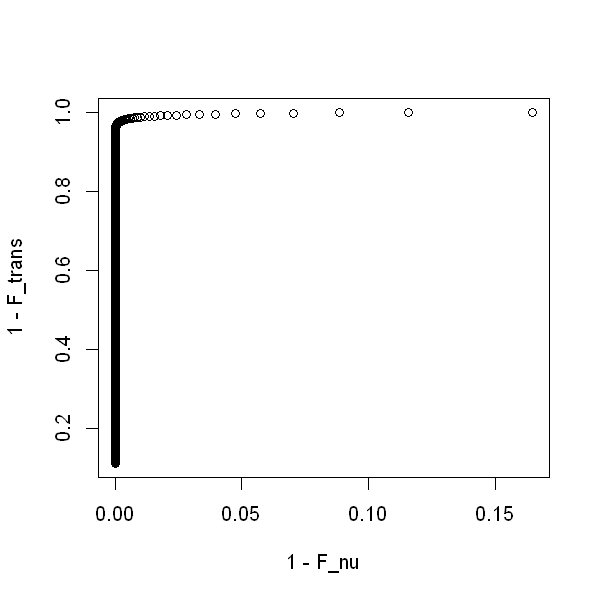

In [17]:
val_range=seq(from=0.01,to=20.0,by=0.01)
F_trans=transmission_proportion(val_range,lambda_mle,k_mle)
F_nu=pgamma(val_range, shape=k_mle, scale=1-lambda_mle/(lambda_mle+k_mle)) # pgamma calculates the CDF of the gamma distribution
plot(1-F_nu,1-F_trans)